## Window length and step size for creating model building data
*This notebook was run at google colab

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras

In [3]:
#df_wd = pd.read_csv('./01_rawdata/raw_wisdm0926_df.csv')  # read in the wisdm datasets

In [4]:
from google.colab import files
uploaded = files.upload()

Saving raw_wisdm0926_df.csv to raw_wisdm0926_df.csv


In [5]:
import io
df_wd = pd.read_csv(io.BytesIO(uploaded['raw_wisdm0926_df.csv']))

In [6]:
df_wd.head(3)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


In [7]:
df_wd_train = df_wd[df_wd['user_id'] <= 30]
df_wd_test = df_wd[df_wd['user_id'] > 30]

In [8]:
print(df_wd_train.shape, df_wd_test.shape)

(898360, 6) (199843, 6)


In [9]:
df_wd_train.head(3)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638


In [10]:
df_wd_test.head(3)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


In [12]:
#define a function to scale the features for building the models
def robustscale_data(df_train,df_test,cols,scaler=RobustScaler()):
    scale_columns = cols
#     scaler = RobustScaler()
    scaler = scaler.fit(df_train[scale_columns])
    df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
    df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())
    return df_train,df_test

In [13]:
# scale the acceleration in the WISDM datasets
df_wd_train,df_wd_test = robustscale_data(df_wd_train,df_wd_test,['x_axis', 'y_axis', 'z_axis'])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
df_wd_train.head(3)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
8489,17,Walking,57869902574000,0.019955,0.252293,-0.090959
8490,17,Walking,57870012316000,-0.055118,0.297966,-0.099228
8491,17,Walking,57870122301000,-0.085505,0.257187,-0.124035


In [15]:
df_wd_test.head(3)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.146278,0.596472,0.118522
1,33,Jogging,49106062271000,0.602662,0.426830,0.209481
2,33,Jogging,49106112167000,0.588363,0.381157,0.000000


In [16]:
def create_dataset(X, y, time_steps=1, step=1):
    '''
    This function creats the timeseries data from the raw datasets.
    X: The input features for building the model
    y: The labels for the corresponding input dataset
    time_step: The window length (number of samples in the time series) of each of the training datasets
    step: The moving distance for the window to generate the next training datasets.
    The difference from (time_step - step) gives the number of overlapping samples between the two nearby rows of training dataset.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [17]:
def create_dataset_X(X, time_steps=1, step=1):
    '''
    This function is very similar as the above function. The only difference is this function does not need inputting labels
    Using this function to create validation datasets.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
#        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
#        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs)#, np.array(ys).reshape(-1, 1)

#### Using WISDM datasets to scan for the optimized window size and steps to create model building datasets 

In [69]:
#define a function to scan the window length ans windwo shifting step

def fast_lstm_model(time_steps,step,df_train = df_wd_train, df_test = df_wd_test,epo_num = 20):
    '''
    Giving the time_steps, steps, train datasets, testing datasets, number of epochs, this function builds a LSTM Neural Network with the training datasets, and evaluate the model by
    The testing datasets. At the end, it returns the loss functin value, accuracy, time steps and step with a list.
    
    Input
        time_steps: The window size (number of samples) for building one row of the trainning/testing datasets
        step: The shift distance for building the next row of the training/testing datasets, (time_steps - step) gives the overlapping of two nearby rows
        df_train: Dataframe used to build the training datasets 
        df_test: Dataframe used to build the testing datasets
        epo_num: Number of epochs for building the Neural Network
    Output
        A list has the loss, accuracy, window size, and step of the neural network applied to the testing datasets
    '''
    
    # Create training datasets 
    X2_wd_train, y2_wd_train = create_dataset(
    df_train[df_train.columns[-3:]],
    df_train.activity,
    time_steps,
    step)
    # Create testing datasets
    X2_wd_test, y2_wd_test = create_dataset(
    df_test[df_test.columns[-3:]],
    df_test.activity,
    time_steps,
    step)
    
    # Create the one hot encoder for labels
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc = enc.fit(y2_wd_train)
    y2_wd_train = enc.transform(y2_wd_train)
    y2_wd_test = enc.transform(y2_wd_test)

    # Define the LSTM model layers
    model2_wd = keras.Sequential()
    model2_wd.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X2_wd_train.shape[1], X2_wd_train.shape[2]]
        )
      )
    )
    model2_wd.add(keras.layers.Dropout(rate=0.5))
    model2_wd.add(keras.layers.Dense(units=128, activation='relu'))
    model2_wd.add(keras.layers.Dense(y_wd_train.shape[1], activation='softmax'))
    model2_wd.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    # Fit the model
    model2_wd.fit(
    X2_wd_train, y2_wd_train,
    epochs=epo_num,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose = 0
    )
    # return the loss and accuracy of the model on the testing datasets
    return model2_wd.evaluate(X2_wd_test,y2_wd_test,verbose=0)

In [74]:
import timeit

In [77]:
# Define the scan parameters
windows = [20,40,80,100,120,160,200,400]
step_ratio = [0.2,0.4,0.6,0.8]

t_start = timeit.default_timer()
evas = []
for win in windows:
    for ratio in step_ratio:
        time_steps = win
        step = int(ratio*win)
        t0_loop = timeit.default_timer()
        eva = fast_lstm_model(time_steps=win,step=step,epo_num=20)
        eva.append([win,step])
        evas.append(eva)
        t1_loop = timeit.default_timer()
        print(f'loop time for winsow {win} and step {step} is: {t1_loop - t0_loop}')
t_end = timeit.default_timer()
print('Total time for searching optimized window and step was:')
print(t_end - t_start)

loop time for winsow 20 and step 4 is: 485.19430632500007
loop time for winsow 20 and step 8 is: 244.00501267099935
loop time for winsow 20 and step 12 is: 161.84898320399952
loop time for winsow 20 and step 16 is: 124.52927755600012
loop time for winsow 40 and step 8 is: 287.3668669230001
loop time for winsow 40 and step 16 is: 144.60512564000055
loop time for winsow 40 and step 24 is: 99.39594772800046
loop time for winsow 40 and step 32 is: 73.89359030699961
loop time for winsow 80 and step 16 is: 188.27109213900076
loop time for winsow 80 and step 32 is: 96.89059980100137
loop time for winsow 80 and step 48 is: 66.03898040000058
loop time for winsow 80 and step 64 is: 51.9627370879989
loop time for winsow 100 and step 20 is: 174.59834489499917
loop time for winsow 100 and step 40 is: 89.06347100600033
loop time for winsow 100 and step 60 is: 59.074464321998676
loop time for winsow 100 and step 80 is: 45.24979483499919
loop time for winsow 120 and step 24 is: 158.95463121800094
loop

In [79]:
evas

[[0.7812128067016602, 0.8377772569656372, [20, 4]],
 [0.6069954037666321, 0.8667627573013306, [20, 8]],
 [0.6000770330429077, 0.8461446166038513, [20, 12]],
 [0.4886976182460785, 0.8677235841751099, [20, 16]],
 [0.3710367679595947, 0.8963004350662231, [40, 8]],
 [0.40016624331474304, 0.9074311256408691, [40, 16]],
 [0.3778120279312134, 0.8878212571144104, [40, 24]],
 [0.43649712204933167, 0.8991031646728516, [40, 32]],
 [0.3767133951187134, 0.9000480771064758, [80, 16]],
 [0.5868149995803833, 0.878904402256012, [80, 32]],
 [0.3926923871040344, 0.9113407135009766, [80, 48]],
 [0.3529728651046753, 0.909673273563385, [80, 64]],
 [0.3203164041042328, 0.9302162528038025, [100, 20]],
 [0.5192607641220093, 0.8886663913726807, [100, 40]],
 [0.5002130270004272, 0.8762762546539307, [100, 60]],
 [0.4952281713485718, 0.8718461990356445, [100, 80]],
 [0.364149272441864, 0.9216534495353699, [120, 24]],
 [0.5344456434249878, 0.882239818572998, [120, 48]],
 [0.33994972705841064, 0.9008651971817017, [1

In [121]:
evas_df = pd.DataFrame([[x[0],x[1],x[2][0],x[2][1]] for x in evas],columns=['loss','accuracy','window','step'])

In [122]:
evas_df.head(2)

,loss,accuracy,window,step
0,0.781213,0.837777,20,4
1,0.606995,0.866763,20,8


In [123]:
evas_df.to_csv('lstm_ep20_window_step_scan.csv',index=False)

In [1]:
import pandas as pd
evas = pd.read_csv('./02_models/lstm_ep20_window_step_scan.csv')

In [2]:
evas.head()

,loss,accuracy,window,step
0,0.781213,0.837777,20,4
1,0.606995,0.866763,20,8
2,0.600077,0.846145,20,12
3,0.488698,0.867724,20,16
4,0.371037,0.896300,40,8


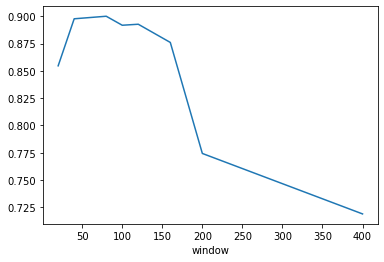

In [13]:
evas.groupby(by='window').mean()['accuracy'].plot();

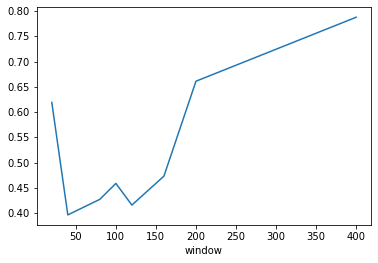

In [14]:
evas.groupby(by='window').mean()['loss'].plot();

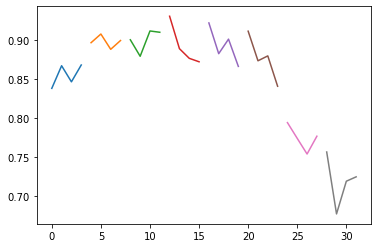

In [13]:
#[20,40,80,100,120,160,200,400]
evas['accuracy'][evas['window'] == 20].plot()
evas['accuracy'][evas['window'] == 40].plot()
evas['accuracy'][evas['window'] == 80].plot()
evas['accuracy'][evas['window'] == 100].plot()
evas['accuracy'][evas['window'] == 120].plot()
evas['accuracy'][evas['window'] == 160].plot()
evas['accuracy'][evas['window'] == 200].plot()
evas['accuracy'][evas['window'] == 400].plot();

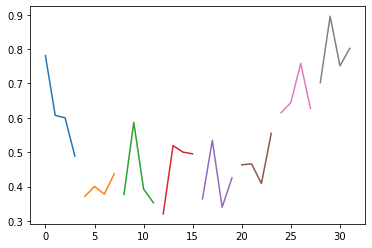

In [14]:
evas['loss'][evas['window'] == 20].plot()
evas['loss'][evas['window'] == 40].plot()
evas['loss'][evas['window'] == 80].plot()
evas['loss'][evas['window'] == 100].plot()
evas['loss'][evas['window'] == 120].plot()
evas['loss'][evas['window'] == 160].plot()
evas['loss'][evas['window'] == 200].plot()
evas['loss'][evas['window'] == 400].plot();

**Comments**

- From the above window length and step size scans, it seemed that window length = 40, 80, and 100 gave lowe loss and hight accuracy
- Considering the optimized ratio found in EDA section, **window length = 80, step size = 16** were selected for WISDM datasets. As one can see in section 6, creating model building datasets with these parameters(window length=80) gave better models than window length = 200.
- For the MS dataset, similar scans had been done at colab too, and the final selections were **window length = 200, step size = 40**